In [1]:
import numpy as np
import tensorflow as tf
from preppy import Preppy
from tensorflow.contrib.seq2seq import *
from tensorflow.python.layers.core import Dense

Make a dataset by reading the train 

In [2]:
def expand(x):
    x['length'] = tf.expand_dims(tf.convert_to_tensor(x['length']),0)
    return x
def deflate(x):
    x['length'] = tf.squeeze(x['length'])
    return x

In [3]:
tf.reset_default_graph()
dataset_train = tf.data.TFRecordDataset(['./data/seq2seq/train.tfrecord']).map(Preppy.parse)
dataset_val = tf.data.TFRecordDataset(['./data/seq2seq/val.tfrecord']).map(Preppy.parse)

In [4]:
dataset_train.output_shapes

{'sentence': TensorShape([Dimension(None)])}

In [5]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))

In [6]:
batched_train = dataset_train.padded_batch(32,padded_shapes={
   # "length":tf.TensorShape([1, None]),
    "sentence":tf.TensorShape([None])
})

batched_val = dataset_val.padded_batch(32,padded_shapes={
   # "length":tf.TensorShape([1, None]),
    "sentence":tf.TensorShape([None])
})

handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(
    handle, batched_train.output_types, batched_train.output_shapes)

next_item = iterator.get_next()

In [7]:
batched_train.output_shapes

{'sentence': TensorShape([Dimension(None), Dimension(None)])}

In [8]:
iterator_train = batched_train.make_initializable_iterator()
iterator_val = batched_val.make_initializable_iterator()

handle_train = sess.run(iterator_train.string_handle())
handle_val = sess.run(iterator_val.string_handle())

In [9]:
class Model():
    def __init__(self, inputs, rnn_size, vocab_size, embedding_dim, batch_size):
        
        self.sentence = sentence =  inputs['sentence']
        length = tf.count_nonzero(sentence, 1, dtype=tf.int32)
        
        self.lr = tf.placeholder(shape=None,dtype=tf.float32)
        
        # define embedding layer
        self.embedding = tf.Variable(
            tf.truncated_normal(shape=[vocab_size, embedding_dim], stddev=0.1), 
            name='embedding')

        # define encoder
        encoder = self._get_simple_lstm(rnn_size)

        input_x_embedded = tf.nn.embedding_lookup(self.embedding, sentence)

        encoder_outputs, self.encoder_state = tf.nn.dynamic_rnn(encoder, input_x_embedded, length, dtype=tf.float32)
        
        self.target_input_ids = sentence
        self.decoder_seq_length = length
        
        target_embeddeds = tf.nn.embedding_lookup(self.embedding, self.target_input_ids)
        helper = TrainingHelper(target_embeddeds, self.decoder_seq_length)

        fc_layer = Dense(vocab_size)
        decoder_cell = self._get_simple_lstm(rnn_size)
        decoder = BasicDecoder(decoder_cell, helper, self.encoder_state, fc_layer)

        self.logits, final_state, final_sequence_lengths = dynamic_decode(decoder)

        self.targets = tf.reshape(sentence, [-1])
        self.logits_flat = tf.reshape(self.logits.rnn_output, [-1, vocab_size])
		
        self.cost = tf.losses.sparse_softmax_cross_entropy(self.targets, self.logits_flat)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.minimize(self.cost)
        """
        # define train op
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars), 3)

        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))
        """
        
    def _get_simple_lstm(self, rnn_size):
        lstm_layers = tf.contrib.rnn.LSTMCell(rnn_size) 
        return lstm_layers

In [10]:
M = Model(next_item, rnn_size = 50, vocab_size = 5728, embedding_dim = 50, batch_size=32)
sess.run(tf.global_variables_initializer())

In [11]:
loss_train = []
loss_val = []
for epoch in range(5):
    sess.run(iterator_train.initializer)
    print("Training %d/2"%(epoch))
    while True:
        try:
            _, loss = sess.run([M.train_op, M.cost],feed_dict={handle: handle_train, M.lr:0.0001})
            loss_train.append(loss)
        except tf.errors.OutOfRangeError:
            break
        except tf.errors.DataLossError:
            break
    
    print("Validation %d/2"%(epoch))
    sess.run(iterator_val.initializer)
    while True:
        try:
            loss = sess.run(M.cost, feed_dict={handle: handle_val})
            loss_val.append(loss)
            #print(loss)
        except tf.errors.OutOfRangeError:
            break
        except tf.errors.DataLossError:
            break
    
print("finish")

Training 0/2
Validation 0/2
Training 1/2
Validation 1/2
Training 2/2
Validation 2/2
Training 3/2
Validation 3/2
Training 4/2
Validation 4/2
finish


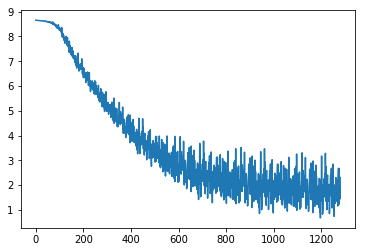

In [14]:
import matplotlib.pyplot as plt
plt.plot(loss_train)
plt.show()

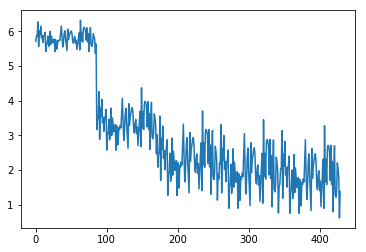

In [13]:
import matplotlib.pyplot as plt
plt.plot(loss_val)
plt.show()